## ResNet-18

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun (2015). Deep Residual Learning for Image Recognition [link](https://arxiv.org/pdf/1512.03385)

ในงานของ He, Zhang, Ren, และ Sun (2015) เรื่อง “Deep Residual Learning for Image Recognition” — หรือที่รู้จักกันว่า ResNet — ผู้เขียนเสนอแนวคิด Residual Learning เพื่อแก้ปัญหาที่เกิดเมื่อเพิ่มความลึกของโครงข่ายประสาทเทียมแล้วประสิทธิภาพกลับลดลง (degradation problem).

โมเดลนี้ใช้ skip connections หรือ identity shortcuts เพื่อให้แต่ละ layer เรียนรู้ “residual mapping” แทนการเรียนรู้ mapping ตรง ๆ ช่วยให้ gradient ไหลย้อนกลับได้ราบรื่นขึ้น และสามารถเทรนโมเดลลึกกว่า 100 ชั้นได้โดยไม่สูญเสียความแม่นยำ.

ผลลัพธ์คือ ResNet ทำลายสถิติในงาน ImageNet 2015 โดยลด error rate ลงอย่างมาก และกลายเป็นสถาปัตยกรรมพื้นฐานของโมเดลสมัยใหม่เกือบทั้งหมดในงานด้าน Computer Vision.

#### ResNet-18 Architecture

Input Layer
- ขนาด: 224×224×3 (ภาพสี RGB)

##### Conv1: Convolution Layer
- ฟิลเตอร์: 64
- Kernel size: 7×7
- Stride: 2
- Padding: 3
- Activation: ReLU
- Normalization: Batch Normalization (BN)
- Pooling: Max Pooling 3×3, stride 2
- Output: 56×56×64

##### Conv2_x: Residual Block (2 Blocks)
Block 1
- Conv1: 3×3, 64 filters, stride 1, padding 1
- Conv2: 3×3, 64 filters, stride 1, padding 1
- Shortcut: Identity (no projection)
- Activation: ReLU
- Output: 56×56×64

Block 2
- Conv1: 3×3, 64 filters, stride 1, padding 1
- Conv2: 3×3, 64 filters, stride 1, padding 1
- Shortcut: Identity
- Activation: ReLU
- Output: 56×56×64

##### Conv3_x: Residual Block (2 Blocks)
Block 1
- Conv1: 3×3, 128 filters, stride 2, padding 1
- Conv2: 3×3, 128 filters, stride 1, padding 1
- Shortcut: 1×1 Conv (stride 2)
- Activation: ReLU
- Output: 28×28×128

Block 2
- Conv1: 3×3, 128 filters, stride 1, padding 1
- Conv2: 3×3, 128 filters, stride 1, padding 1
- Shortcut: Identity
- Activation: ReLU
- Output: 28×28×128

##### Conv4_x: Residual Block (2 Blocks)
Block 1
- Conv1: 3×3, 256 filters, stride 2, padding 1
- Conv2: 3×3, 256 filters, stride 1, padding 1
- Shortcut: 1×1 Conv (stride 2)
- Activation: ReLU
- Output: 14×14×256

Block 2
- Conv1: 3×3, 256 filters, stride 1, padding 1
- Conv2: 3×3, 256 filters, stride 1, padding 1
- Shortcut: Identity
- Activation: ReLU
- Output: 14×14×256

##### Conv5_x: Residual Block (2 Blocks)

Block 1
- Conv1: 3×3, 512 filters, stride 2, padding 1
- Conv2: 3×3, 512 filters, stride 1, padding 1
- Shortcut: 1×1 Conv (stride 2)
- Activation: ReLU
- Output: 7×7×512

Block 2
- Conv1: 3×3, 512 filters, stride 1, padding 1
- Conv2: 3×3, 512 filters, stride 1, padding 1
- Shortcut: Identity
- Activation: ReLU
- Output: 7×7×512

##### Average Pooling Layer
- Global Average Pooling 7×7
- Output: 1×1×512

##### Fully Connected (FC) / Output Layer
- Neurons: 1000 (สำหรับ ImageNet)
- Activation: Softmax (ใช้จำแนกภาพ)

### Install Libraries

- torch
- - PyTorch หลัก ใช้สร้างโมเดล Deep Learning, ทำคำนวณแบบ tensor (คล้าย NumPy แต่ optimized บน GPU), training neural network

- torchvision
- - เป็น extension สำหรับงาน Computer Vision เช่น โหลด datasets (MNIST, CIFAR, ImageNet), มี transforms (resize, normalize) และโมดูลโมเดลสำเร็จรูป (ResNet, VGG ฯลฯ)

- torchmetrics 
- - เอาไว้ใช้คำนวณ metrics สำหรับประเมินโมเดล เช่น Accuracy, Precision, Recall, F1-score โดยออกแบบมาให้ใช้งานง่ายและทำงานร่วมกับ PyTorch Lightning หรือ training loop ปกติ
  
- matplotlib
- - library สำหรับ การ plot กราฟและ visualization เช่น แสดงผลการ training loss, accuracy per epoch, ดูรูปภาพใน dataset ฯลฯ
  

- numpy
- - library สำหรับการคำนวณเชิงตัวเลข (Numerical Computation) ใช้สำหรับจัดการ array และ matrix (ข้อมูลหลายมิติ) ได้อย่างมีประสิทธิภาพ และรองรับการคำนวณทางคณิตศาสตร์ต่าง ๆ

### Set Up Environments

In [1]:
import os, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix
import matplotlib.pyplot as plt
from pathlib import Path

# fix random seed for reproducibility
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# For reproducibility when using CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")  # for Apple Silicon GPU
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")  # for NVIDIA GPU
else:
    DEVICE = torch.device("cpu")   # use CPU if no GPU is available

print("Using device:", DEVICE)

Using device: mps


### Transforms & Datasets
- using CIFAR-100 [link](https://www.cs.toronto.edu/~kriz/cifar.html) 
- Download / Load Datasets (with transforms)
- Clean Datasets
- Preprocess (Split train/val)
- Display / Inspect 

In [ ]:
# mean and std for CIFAR-100
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

# Base transforms (no augmentation) for validation and test sets
base_transforms = transforms.Compose([
    transforms.Resize(256), # resize to larger size before crop
    transforms.CenterCrop(224), # center crop
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

# Augmentation for training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # resize and crop
    transforms.RandomHorizontalFlip(), # random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

#### Download / Load Datasets

In [3]:
DATA_DIR = "../data" # directory to store datasets

# Download / Load training and test datasets
train_ds_raw = datasets.CIFAR100(
    root=DATA_DIR, train=True, download=True, transform=train_transforms
)
test_ds = datasets.CIFAR100(
    root=DATA_DIR, train=False, download=True, transform=base_transforms
)

# Print dataset sizes
print(f"Train samples: {len(train_ds_raw)}, Test samples: {len(test_ds)}")

Train samples: 50000, Test samples: 10000


#### Clean Datasets

In [4]:
class SafeDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.bad_indices = []

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        try:
            return self.ds[idx]
        except Exception as e:
            self.bad_indices.append(idx)
            # If a bad sample is encountered, return a random good sample
            ridx = random.randint(0, len(self.ds) - 1)
            return self.ds[ridx]

train_ds = SafeDataset(train_ds_raw)

#### Split train/val

In [5]:
# Split train_ds into training and validation sets
VAL_RATIO = 0.1

# Determine sizes
val_size = int(len(train_ds) * VAL_RATIO) # 10% for validation
train_size = len(train_ds) - val_size # remaining for training

# Split the dataset
train_ds, val_ds = random_split(
    train_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

# Print sizes of the datasets
print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")

Train: 45000 | Val: 5000


#### DataLoader

In [6]:
BATCH_SIZE = 32 # batch size for DataLoader
# Create DataLoader for each dataset
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

#### Display / Inspect

/Users/morse/Documents/morse-workspaces/computer-vision-engineer/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


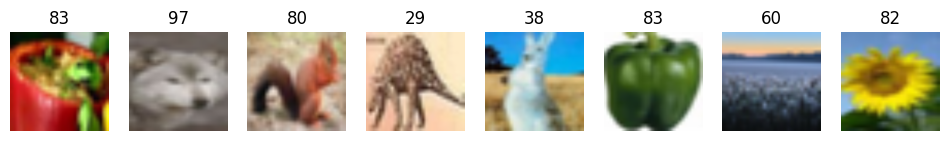

In [7]:
# Function to show a batch of images
def show_batch(dl, n=8):
    imgs, labels = next(iter(dl))
    imgs = imgs[:n]
    labels = labels[:n]

    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = imgs[i].permute(1, 2, 0).cpu().numpy() * np.array(CIFAR100_STD) + np.array(CIFAR100_MEAN)
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(int(labels[i]))
        plt.axis("off")
    plt.show()

# Show a batch of training images
show_batch(train_loader, n=8)

#### ResNet-18 (Model Architecture)

- ปรับให้รองรับ CIFAR-100 (100 classes) ซึ่งมีภาพขนาด 32×32 (ขยายเป็น 224×224 เหมือนกับ AlexNet เพื่อเทรนบนโครงสร้างแบบ ImageNet ได้โดยตรง)

- ResNet-18 ประกอบด้วย 18 เลเยอร์ที่มีพารามิเตอร์ (Convolution + Fully Connected) โดยใช้แนวคิดใหม่ที่เรียกว่า Residual Learning เพื่อแก้ปัญหาการฝึกโมเดลลึก ๆ ให้มีประสิทธิภาพ

- ใช้ Batch Normalization (BN) หลังทุก convolution layer เพื่อช่วยให้การเรียนรู้มีเสถียรภาพ

- ใช้ ReLU เป็น activation function เช่นเดียวกับ AlexNet

- โครงสร้างหลักแบ่งเป็น 5 stage (Conv1 + Conv2_x → Conv5_x)
โดยแต่ละ stage ประกอบด้วย Residual Block ซึ่งมี “skip connection” หรือทางลัดระหว่าง input และ output ของ block เพื่อให้ gradient ไหลย้อนกลับได้ดีขึ้นในระหว่างการเทรน

In [8]:
# Define the BasicBlock for ResNet
class BasicBlock(nn.Module):
    expansion = 1  # expansion factor for output channels

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # 2 convolution layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (identity or projection)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:

            # Projection shortcut to match dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    # Forward pass
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)  # residual connection
        out = F.relu(out)
        return out

In [10]:
# Define the ResNet-18 architecture

class ResNet18(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.in_channels = 64

        # Initial Conv Layer: 7x7, 64 filters, stride 2, padding 3
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # 3x3 Max Pooling, stride 2, padding 1
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Blocks (Conv2_x → Conv5_x)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)   # Conv2_x
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)  # Conv3_x
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)  # Conv4_x
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)  # Conv5_x

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        # Initialize weights
        self._initialize_weights()

    # Create a layer with multiple blocks
    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        
        # Block early of each stage may have stride > 1 (downsample)
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        
        # Block nexts use stride = 1
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    # He initialization for weights
    def _initialize_weights(self):

        # Initialize weights using He initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    # Forward pass
    def forward(self, x):
        # Input: 224×224×3
        x = self.conv1(x) # 112x112
        x = self.bn1(x) # 112x112
        x = self.relu(x) # 112x112
        x = self.maxpool(x) # 56x56

        # Residual blocks
        x = self.layer1(x)  # 56x56
        x = self.layer2(x)  # 28x28
        x = self.layer3(x)  # 14x14
        x = self.layer4(x)  # 7x7

        # Classification head
        x = self.avgpool(x) # 1x1
        x = torch.flatten(x, 1) # flatten
        x = self.fc(x)
        return x

In [11]:
num_classes = 100 # CIFAR-100 has 100 classes

# Determine if LRN should be used based on device capabilities
USE_LRN = not torch.backends.mps.is_available() 

# Create the model and move it to the device (MPS / CUDA / CPU)
model = ResNet18(num_classes=num_classes).to(DEVICE)

# Show total number of parameters in the model
sum(p.numel() for p in model.parameters()), model

(11227812,
 ResNet18(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shortcut): Sequential()
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (

In [12]:
# Enable TF32 for MPS (Apple Silicon) for better performance
torch.backends.mps.allow_tf32 = True

### Loss, Optimizer, Metrics

In [ ]:
# Hyperparameters
LR = 0.1 # learning rate
MOMENTUM = 0.9 # momentum for SGD
EPOCHS = 20 # number of training epochs
WEIGHT_DECAY = 5e-4  # L2 regularization
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for 100-class classification
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=LR, 
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler - StepLR
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=30, # reduce LR every 30 epochs
    gamma=0.1 # multiply by 0.1
)

# Metrics
acc_metric_val = MulticlassAccuracy(num_classes=num_classes).to(DEVICE)
acc_metric_test = MulticlassAccuracy(num_classes=num_classes).to(DEVICE)

### Train / Validate Loop (with early stopping)

In [14]:
# Training function for one epoch

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        # Forward pass
        logits = model(x)
        loss = criterion(logits, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total

In [15]:
# Evaluation function

def evaluate(model, loader, criterion, metric):
    model.eval()
    metric.reset()
    running_loss, total = 0.0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            running_loss += loss.item() * x.size(0)
            total += y.size(0)
            metric.update(logits, y)
    return running_loss/total, metric.compute().item()

In [ ]:
# Training / Validation loop with early stopping

best_val_acc, best_state = 0.0, None
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    # Train
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)

    # Validation
    val_loss, val_acc = evaluate(model, val_loader, criterion, acc_metric_val)

    # Adjust learning rate
    scheduler.step()

    # Record history
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Save best model (early stopping)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    elapsed = time.time() - start_time
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
          f"time {elapsed:.1f}s")

In [ ]:
# Load the best model state (early stopping)
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(DEVICE)

### Plot Accuracy & Loss per Epoch

In [ ]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Test & Evaluate (accuracy, confusion matrix, per-class report)

In [ ]:
# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, acc_metric_test)
print(f"TEST | loss {test_loss:.4f} | acc {test_acc:.4f}")

In [ ]:
# Confusion Matrix
cm_metric = MulticlassConfusionMatrix(num_classes=num_classes).to(DEVICE)
model.eval()
cm_metric.reset()

# Compute confusion matrix
with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        cm_metric.update(logits, y)
cm = cm_metric.compute().cpu().numpy()

In [ ]:
# Plot confusion matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (MNIST)')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks); plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
# Save the model checkpoint
Path("checkpoints").mkdir(exist_ok=True)
torch.save(model.state_dict(), "checkpoints/resnet_18_cifar100.pt")

In [ ]:
# Load the model checkpoint
model_pretrained = ResNet18().to(DEVICE)
model_pretrained.load_state_dict(torch.load("checkpoints/resnet_18_cifar100.pt", map_location=DEVICE))
model_pretrained.eval()